In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
import noisereduce as nr
torch.manual_seed(10)

/anaconda/envs/py36/lib/python3.6/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [67]:
import pandas as pd
audio = pd.read_csv('audio_df_improvised.csv')

audio.reset_index(inplace=True)
audio.head()

,index,start_time,end_time,wav_file,emotion,val,act,dom
0,0,6.2901,8.2357,Ses01F_impro01_F000,neu,2.5,2.5,2.5
1,1,10.0100,11.3925,Ses01F_impro01_F001,neu,2.5,2.5,2.5
2,2,14.8872,18.0175,Ses01F_impro01_F002,neu,2.5,2.5,2.5
3,3,27.4600,31.4900,Ses01F_impro01_F005,neu,2.5,3.5,2.0
4,4,85.2700,88.0200,Ses01F_impro01_F012,ang,2.0,3.5,3.5


In [75]:
def get_mfcc(file_path, med_duration ,sr=None, n_fft=2048, hop_length=256, n_mels=128, fmin=100, fmax=15000, top_db=80):
    med_duration = int(np.floor(med_duration))
    wav,sr = librosa.load(file_path,sr=sr)
    wav = nr.reduce_noise(audio_clip=wav, noise_clip=wav, verbose=False)
    if wav.shape[0]<(med_duration*sr):
        wav=np.pad(wav,int( np.ceil( ((med_duration*sr)-wav.shape[0])/2 ) ),mode='constant', constant_values=(0, 0))
    else:
        wav=wav[:(med_duration*sr)]
    


    mfcc=librosa.feature.mfcc(wav, sr=sr, n_mfcc=128, dct_type=2)
#     librosa.decompose.nn_filter(spec, aggregate=np.median, metric='cosine')
#     spec_db=librosa.power_to_db(spec)
    return mfcc

In [54]:
def mfcc_to_image(mfcc, eps=1e-6):
    mean = mfcc.mean()
    std = mfcc.std()
    mfcc_norm = (mfcc - mean) / (std + eps)
    mfcc_min, mfcc_max = mfcc_norm.min(), mfcc_norm.max()
    mfcc_scaled = 255 * (mfcc_norm - mfcc_min) / (mfcc_max - mfcc_min)

    return mfcc_scaled

(128, 126)

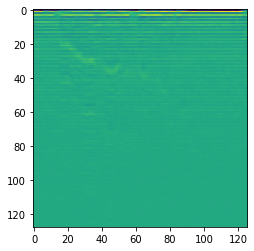

In [55]:
plt.imshow( mfcc_to_image(get_mfcc('/data/home/advaitmb/datasets/sentences/' + audio.wav_file[56] + '.wav', 4 )) )
get_mfcc('/data/home/advaitmb/datasets/sentences/' + audio.wav_file[4] + '.wav', 4 ).shape

In [69]:
# We split the dataframe into train and test segments
from sklearn.utils import shuffle
train = audio[:2212]
train = shuffle(train)
valid = audio[2212:]

In [57]:
rnn = nn.LSTM(128, hidden_size = 64, num_layers=2, bidirectional=True, batch_first=True)
x= torch.from_numpy(get_mfcc('/data/home/advaitmb/datasets/sentences/' + audio.wav_file[1000] + '.wav', 4 ).T).unsqueeze(0)
print(x.shape)
out, _ = rnn(x)
print(out.reshape(out.size(0), -1).shape)



torch.Size([1, 126, 128])
torch.Size([1, 16128])


In [76]:
class IEMOCAP(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())
        print(self.categories)
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            
            #If all files are stored in a folder named sentences
            file_path = base + '/' + row[in_col] + '.wav'
            
            
            self.data.append(( get_mfcc(file_path, 4).T ))
            self.labels.append(self.c2i[row['emotion']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [77]:
train_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', train, 'wav_file', 'emotion')
valid_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', valid, 'wav_file', 'emotion')
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

  0%|          | 3/2212 [00:00<01:54, 19.28it/s]

['ang', 'hap', 'neu', 'sad']


  0%|          | 3/731 [00:00<00:41, 17.59it/s]

['ang', 'hap', 'neu', 'sad']


100%|██████████| 731/731 [00:40<00:00, 17.94it/s]


In [78]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(128, hidden_size = 64, num_layers=2, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(126*64*2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        
    def forward(self, x):
        x,_ = self.rnn(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [79]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [80]:
net = Network()
net = net.to(device)

In [81]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print("Changed learning rate to {}".format(new_lr))
    return optimizer

In [82]:
def train_model(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
    
    for epoch in tqdm(range(1,epochs+1)):
        
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)


        print("Epoch - {} Train-Loss : {}".format(epoch, np.mean(train_losses[-1])))
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())

        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        print("Epoch - {} Valid-Loss : {} Valid-Accuracy : {}".format(epoch, np.mean(valid_losses[-1]), accuracy ))
        




In [83]:
learning_rate = 2e-5
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.01)
epochs = 20
loss_fn = nn.CrossEntropyLoss()
train_losses=[]
valid_losses=[]

In [84]:
train_model(net, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 1.3474487083298818


  5%|▌         | 1/20 [00:03<01:12,  3.82s/it]

Epoch - 1 Valid-Loss : 1.3117262539656267 Valid-Accuracy : 0.39261285909712723
Epoch - 2 Train-Loss : 1.319954710347312


 10%|█         | 2/20 [00:07<01:07,  3.75s/it]

Epoch - 2 Valid-Loss : 1.2939168370288352 Valid-Accuracy : 0.43912448700410395
Epoch - 3 Train-Loss : 1.2956951311656406


 15%|█▌        | 3/20 [00:10<01:02,  3.69s/it]

Epoch - 3 Valid-Loss : 1.2809025774831357 Valid-Accuracy : 0.44459644322845415
Epoch - 4 Train-Loss : 1.254569593497685


 20%|██        | 4/20 [00:14<00:58,  3.66s/it]

Epoch - 4 Valid-Loss : 1.268115240594615 Valid-Accuracy : 0.4582763337893297
Epoch - 5 Train-Loss : 1.2229944808142525


 25%|██▌       | 5/20 [00:18<00:54,  3.63s/it]

Epoch - 5 Valid-Loss : 1.2373762286227683 Valid-Accuracy : 0.49658002735978113
Epoch - 6 Train-Loss : 1.1982578941753932


 30%|███       | 6/20 [00:21<00:50,  3.62s/it]

Epoch - 6 Valid-Loss : 1.2532941724943079 Valid-Accuracy : 0.454172366621067
Epoch - 7 Train-Loss : 1.1758826885904585


 35%|███▌      | 7/20 [00:25<00:46,  3.61s/it]

Epoch - 7 Valid-Loss : 1.2149775805680647 Valid-Accuracy : 0.5280437756497948
Epoch - 8 Train-Loss : 1.1612745659691948


 40%|████      | 8/20 [00:28<00:43,  3.60s/it]

Epoch - 8 Valid-Loss : 1.215589217517687 Valid-Accuracy : 0.5116279069767442
Epoch - 9 Train-Loss : 1.1479431322642735


 45%|████▌     | 9/20 [00:32<00:39,  3.59s/it]

Epoch - 9 Valid-Loss : 1.2232074167417444 Valid-Accuracy : 0.493844049247606
Changed learning rate to 2.0000000000000003e-06
Epoch - 10 Train-Loss : 1.1383748531341553


 50%|█████     | 10/20 [00:36<00:35,  3.59s/it]

Epoch - 10 Valid-Loss : 1.2144900508548901 Valid-Accuracy : 0.5047879616963065
Epoch - 11 Train-Loss : 1.1368671996252877


 55%|█████▌    | 11/20 [00:39<00:32,  3.58s/it]

Epoch - 11 Valid-Loss : 1.2142038552657417 Valid-Accuracy : 0.5143638850889193
Epoch - 12 Train-Loss : 1.1377889326640538


 60%|██████    | 12/20 [00:43<00:28,  3.58s/it]

Epoch - 12 Valid-Loss : 1.2119606370511262 Valid-Accuracy : 0.5129958960328317
Epoch - 13 Train-Loss : 1.1371138146945408


 65%|██████▌   | 13/20 [00:46<00:25,  3.58s/it]

Epoch - 13 Valid-Loss : 1.2128100447032764 Valid-Accuracy : 0.5129958960328317
Epoch - 14 Train-Loss : 1.1343650681631905


 70%|███████   | 14/20 [00:50<00:21,  3.58s/it]

Epoch - 14 Valid-Loss : 1.2138181510178938 Valid-Accuracy : 0.5102599179206566
Epoch - 15 Train-Loss : 1.1356744383062636


 75%|███████▌  | 15/20 [00:53<00:17,  3.57s/it]

Epoch - 15 Valid-Loss : 1.212565453156181 Valid-Accuracy : 0.5116279069767442
Epoch - 16 Train-Loss : 1.1349068743841988


 80%|████████  | 16/20 [00:57<00:14,  3.57s/it]

Epoch - 16 Valid-Loss : 1.2117235608722852 Valid-Accuracy : 0.5143638850889193
Epoch - 17 Train-Loss : 1.1356102023805892


 85%|████████▌ | 17/20 [01:01<00:10,  3.57s/it]

Epoch - 17 Valid-Loss : 1.2098634968633237 Valid-Accuracy : 0.5143638850889193
Epoch - 18 Train-Loss : 1.130644201380866


 90%|█████████ | 18/20 [01:04<00:07,  3.58s/it]

Epoch - 18 Valid-Loss : 1.2142984193304311 Valid-Accuracy : 0.5129958960328317
Epoch - 19 Train-Loss : 1.1313075150762286


 95%|█████████▌| 19/20 [01:08<00:03,  3.57s/it]

Epoch - 19 Valid-Loss : 1.2112386848615564 Valid-Accuracy : 0.5198358413132695
Changed learning rate to 2.0000000000000002e-07
Epoch - 20 Train-Loss : 1.1277709773608617


100%|██████████| 20/20 [01:11<00:00,  3.59s/it]

Epoch - 20 Valid-Loss : 1.2108571684878806 Valid-Accuracy : 0.5198358413132695
